## Tracking de Icebergs

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import shape, mapping
import json
import geemap,ee
import folium
ee.Authenticate()
ee.Initialize()

In [2]:
import math
def distancia_nuevacoor(lat1, lon1, lat2, lon2, escala=6):
    # Convertir grados a radianes
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    
    # Radio de la Tierra en metros
    R = 6371000
    
    # Diferencias de coordenadas
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad

    
    # Fórmula de Haversine
    a = math.sin(delta_lat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(delta_lon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # Distancia
    distancia = R * c
    
    # Extender la coordenada
    lat_nueva_rad = lat2_rad + delta_lat * escala
    lon_nueva_rad = lon2_rad + delta_lon * escala
    
    # Convertir de radianes a grados
    lat_nueva = math.degrees(lat_nueva_rad)
    lon_nueva = math.degrees(lon_nueva_rad)
    
    return round(distancia, 2), round(lat_nueva, 4)  , round(lon_nueva, 4)

In [21]:
def velocidad(coor1, coor2, fecha1, fecha2):
    fecha1 = dt.datetime.strptime(fecha1, '%Y-%m-%d')
    fecha2 = dt.datetime.strptime(fecha2, '%Y-%m-%d')
    tiempo = (fecha1 - fecha2).days
    if tiempo == 0:
        return 1
    lat1, lon1 = coor1
    lat2, lon2 = coor2
    distancia, lat, lon = distancia_nuevacoor(lat1, lon1, lat2, lon2)
    new_coor = [lat, lon]
    velocidad = distancia / tiempo
    return velocidad, new_coor

- Primero definimos nuestro icebergs de interes

Para este proceso, directamente en Google engine seleccionamos manualmente el icebreg de interes. Usando el siguiente codigo.

In [4]:
# var roi = ee.Geometry.Polygon([
#   [[-112, -72.7], [-112, -73.7], [-108.5, -73.7], [-108.5, -72.7], [-112, -72.7]]
# ]);

# var startdate = '2017-04-19' 
# var enddate = '2017-04-20' 

# var S1 = sentinel1
#   // Filter to get images with VV and VH dual polarization.
#   //.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH'))
#   // Filter to get images collected in interferometric wide swath mode.
#   .filterDate(startdate, enddate) 
#   // .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))
#   .filterBounds(roi);
  
# print(S1)
# var img = S1.select("HH")

# var visParams1 = {band: ['HH'], min: -30, max: 0};
# // var visParams2 = {band: ['B4'], max: 10000, min: 0};

# Map.addLayer(img, visParams1, 'S1');

# Definimos "geometry" manualmente
# var geometry = ee.FeatureCollection(geometry)
# Export.table.toDrive(geometry, 'iceberg_' + startdate, 'users/kooala317/Iceberg_tracking')

In [4]:
df = pd.read_csv("Icebergs\iceberg_0007_2020-06-01.csv")
df['geometry'] = df['.geo'].apply(lambda x: shape(json.loads(x)))

gdf = gpd.GeoDataFrame(df, geometry='geometry').set_crs('epsg:4326', inplace=True)

<Axes: >

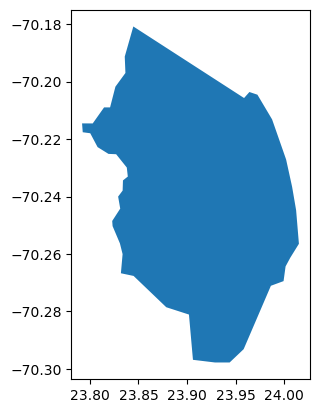

In [5]:
gdf["geometry"].plot()

- Luego, haciendo comparativas de similitud, localizamos el mismo iceberg en una imagen posterior. (Con un cierto margen de error)

#### 1. Pasamos nuestro archivo local a una Feature collection

In [6]:
gdf.columns = [col.replace('.', '_') for col in gdf.columns]

# Verificamos que todas las columnas son strings
for col in gdf.columns:
    if col != 'geometry':
        gdf[col] = gdf[col].astype(str)

# Convertimos el GeoDataFrame a una lista de Features
features = []
for _, row in gdf.iterrows():
    geom = ee.Geometry(mapping(row['geometry']))
    feature = ee.Feature(geom, row.drop('geometry').to_dict())
    features.append(feature)


iceberg = ee.FeatureCollection(features)

#### 2. Una vez obtenida la feature collection del iceberg, obtenemos las imagenes satelitales de esté.

https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD

In [7]:
fecha_inicio = '2020-06-01'
fecha_fin = '2020-06-02'

In [8]:
S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
.filterDate(fecha_inicio, fecha_fin)\
.filterBounds(iceberg)\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))

band = ["HH", "angle"]

img = S1A.select(band).mean().clip(iceberg) 

#### 3. Planteamos una forma de identificar el iceberg. Esta forma requiere calcular cómo varía la distancia desde el centroide hacia los bordes del iceberg. Para ello:

- Definimos una capa de cobertura del iceberg, la cual vale 1 siempre que se abarca el iceberg.

In [9]:
cover = img.select('HH').clip(iceberg).multiply(0).add(1)
cover = cover.addBands(ee.Image.pixelLonLat())

- Definimos una Imagen que vale 1 en el centroide del Iceberg.

In [10]:
centroid = iceberg.geometry().centroid(10).getInfo()['coordinates']

sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1)

- Calculamos el costo acumulativo para recorrer la imagen desde el centroide del iceberg hasta los bordes del iceberg.

In [11]:
cumulativeCost = cover.select('HH').cumulativeCost(
    source = sources,
    maxDistance = 30000,
    geodeticDistance = True
).clip(iceberg)

result = cumulativeCost.reduceRegion(ee.Reducer.toList(), iceberg, scale=200, maxPixels=1e20)
A = result.getInfo()['cumulative_cost'] 

- Calculamos un histograma de la distribucion de las distancias centroide-borde

Text(0, 0.5, 'N')

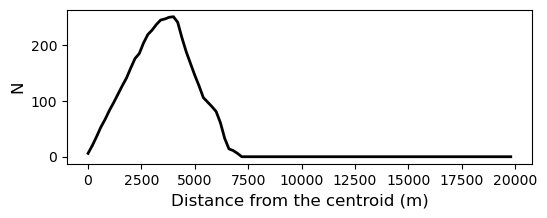

In [12]:
hist1 = {}

scale = 200
max_pix = 20000

fig = plt.subplots(figsize = (6, 2), dpi = 100)
hist1['reference'] = np.histogram(A, int(max_pix/scale), [0, max_pix])

plt.plot(hist1['reference'][1][:-1], hist1['reference'][0], color = "k", linewidth = 2)
plt.xlabel("Distance from the centroid (m)", fontsize = 12)
plt.ylabel("N", fontsize = 12)

- Obtenemos el area real del iceberg

In [13]:
area0 = iceberg.geometry().area(10).getInfo()
print(area0)

63708602.02325422


In [15]:
Map = geemap.Map(center= [centroid[1], centroid[0]], zoom = 10)
visParams1 = {"bands": ['HH'], "min": -30, "max": 0}
Map.addLayer(img, visParams1, 'S1')
Map

Map(center=[-70.23942913791707, 23.911524302848008], controls=(WidgetControl(options=['position', 'transparent…

4. Ahora queremos Trackear nuestro iceberg en un lapso de tiempo usando lo anterior.

En cada iteración segmentaremos la zona objetivo usando snic eh identificaremos el iceberg de estudio usando lo anterior.

In [14]:
ice_area = {}
ice_centroid = {}
mapid_seg = {}
mapid_target = {}

startdate = fecha_inicio; enddate = fecha_fin
center = centroid

buf_dist = 20000 # distancia desde el centroide para buscar icebergs

# Map initialization (note: if you run this code, map is entirely initialized!)
map1 = folium.Map(location=[center[1], center[0]], zoom_start=7, height=550,width=700)

# color codes to visualize the iceberg geometry by time
color_codes = ['red', 'chocolate', 'orange', 'yellow', 'olive', 'lime',
               'green', 'teal', 'cyan', 'blue', 'navy', 'purple']


Dias de estudio

In [15]:
# Cuantos dias queremos estudiar
day_range = range(0, 20)

Calculo Area de cada iceberg

In [16]:
#decidir si mantener o no el parametro maxError=10
def addArea(feature):
    return feature.set({"area": feature.geometry().area(10), "centroid": feature.geometry().centroid(10)})

In [17]:
df_iceberg = pd.DataFrame(columns=['fecha', 'similaridad', 'area', 'centroide', 'poligono', 'source', 'covers'])

In [18]:
def contains_aoi(image, aoi):
    footprint = ee.Geometry(image.geometry())
    contains = footprint.contains(aoi, 1)  # 1 es la tolerancia en metros
    return image.set('contains_aoi', contains)

In [19]:
def contains_aoi_by_percentage(image, aoi, threshold=0.5):
    footprint = ee.Geometry(image.geometry())
    intersection = footprint.intersection(aoi, ee.ErrorMargin(1))
    intersection_area = intersection.area()
    aoi_area = aoi.area()
    percentage_contained = intersection_area.divide(aoi_area)
    return image.set('contains_aoi', percentage_contained.gte(threshold))

2020-06-06 ============================================
Feature 0 >>> area: 63.67 km^2, centroid: [23.882, -70.214], similarity: 0.973


TypeError: cannot unpack non-iterable int object

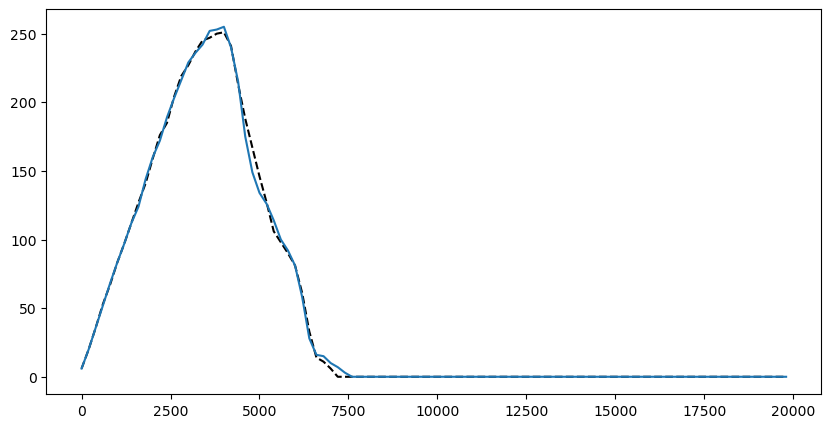

In [22]:
startdate = "2020-06-06"; enddate = "2020-06-07"
center = [23.882, -70.214]
coordenada_anterior = [23.882, -70.214]; fecha_anterior = "2020-06-06"

vectorscale = 40

buf_dist = 30000

fig = plt.subplots(figsize = (10, 5))
plt.plot(hist1['reference'][1][:-1], hist1['reference'][0], label = "reference", color = "k", linestyle = "--")

for day in day_range:
    
    month = dt.datetime.strptime(startdate, "%Y-%m-%d").month
    band = ["HH", "angle"]  # intersted band
    
    aoi = ee.Geometry.Point(center).buffer(buf_dist)

    # Utilizamos las imagenes HH de Sentinel-1
    S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
    .filterDate(startdate, enddate)\
    .filterBounds(aoi)\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))
    
    if S1A.size().getInfo() > 0:
        imageA = S1A.select(band).mean().clip(aoi) # clip image into ROI

        seeds = ee.Algorithms.Image.Segmentation.seedGrid(80);
            
        # Gaussian kernel to softening the image (remove some salt and pepper noise)
        kernel = ee.Kernel.gaussian(3)
        img1 = imageA.convolve(kernel)
        img = img1.select(['HH', 'angle'], ['HH', 'angle'])
            
            
        # segmentamos la imagen con SNIC
        # size = 20, compactness= 5, connectivity= 8, neighborhoodSize = 256
        snic = ee.Algorithms.Image.Segmentation.SNIC(img, 20, 5, 8, 256, seeds)\
        .select(["HH_mean", "angle_mean", "clusters"], ["HH", "angle", "clusters"])
            
        segments = snic.select("clusters").reduceToVectors(
            geometry = snic.geometry(),
            scale = vectorscale,
            geometryType = 'polygon',            
            maxPixels = 1e20
        )     
            
        segimageA = segments.reduceToImage(
            properties = ['label'],
            reducer = ee.Reducer.first()
        ).rename('id')       

        # dividimos los valores HH por los valores de la banda angle para mejorar el contraste entre los icebergs y el mar abierto o el hielo circundante.
        ratio = snic.select("HH").divide(snic.select("angle"))
        # mantenemos solo los valores mayores que -0.2 (icebergs)
        icebergs = ratio.gt(-0.2).selfMask()     
            
        # convertimos los iceberg raster a vectores
        vectors = icebergs.reduceToVectors(
            geometry = icebergs.geometry(),
            scale = vectorscale,
            geometryType = 'polygon',            
            maxPixels = 1e20)

        # permitimos un margen de error del 20% en el area de los icebergs respecto al iceberg objetivo
        area_max = area0 * 1.2
        area_min = area0 * 0.8
        # obtenemos el area y el centroide de los icebergs
        areaAdded = vectors.map(addArea)
        # filtramos los icebergs que tienen un area entre el 80% y el 120% del area objetivo
        target = areaAdded.filter(ee.Filter.gt('area', area_min)).filter(ee.Filter.lt('area', area_max))
            
        num = target.size().getInfo()
        features = target.getInfo()['features']
            
        print(startdate + " ============================================")
        threshold = 0.7
        find = False
        candidates = []
            
        for k in range(0, num): # if there is a valid iceberg
                
            area = features[k]['properties']['area']
            centroid = features[k]['properties']['centroid']['coordinates']
            polygon = ee.FeatureCollection(ee.Geometry.Polygon(features[k]['geometry']['coordinates'][0]))
            sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1)
            covers = snic.select('HH').multiply(0).add(1)

            cumCost = covers.cumulativeCost(
                source = sources,
                maxDistance = 30000,
                geodeticDistance = True
            ).clip(polygon)

            result = cumCost.reduceRegion(ee.Reducer.toList(), polygon, scale = 200)
            cumdist = result.getInfo()['cumulative_cost']
            B = np.histogram(cumdist, int(max_pix/scale), [0, max_pix])  
                
            diff = abs(hist1['reference'][0] - B[0])
            similarity = 1-np.sum(diff)/np.sum(hist1['reference'][0])          
                
            print("Feature {0} >>> area: {1} km^2, centroid: [{2}, {3}], similarity: {4}".format(
                k, round(area/1e6,2), round(centroid[0],3), round(centroid[1], 3), round(similarity, 3)
            ))                       
                
            if similarity >= threshold: 
                threshold = similarity
                find = True
                candidates.append((startdate, similarity, area, centroid, polygon, sources, covers, B))
    else:
        print(f'No hay imagenes para la fecha: {startdate}')
        find = False
    
    if find == True:
        startdate = candidates[-1][0]
        similarity = candidates[-1][1]
        area = candidates[-1][2]
        centroid = candidates[-1][3]
        polygon = candidates[-1][4]
        sources = candidates[-1][5]
        covers = candidates[-1][6]
        B = candidates[-1][7]
        df_iceberg.loc[len(df_iceberg.index)] = [startdate, similarity, area, centroid, polygon, sources, covers]

        ice_area[startdate] = area
        ice_centroid[startdate] = centroid
        hist1[startdate] = B 
        plt.plot(B[1][:-1], B[0], label = startdate + "_" + str(k))
        
        vel, new_center = velocidad(center, coordenada_anterior, startdate, fecha_anterior)
        if vel < 10000:
            center = centroid
            buf_dist = 30000
        else:
            center = new_center
            buf_dist = 30000 + vel 

        coordenada_anterior = centroid
        fecha_anterior = startdate
    
    else:
        buf_dist += 30000
        if buf_dist >= 60000:
            print(f'Se aumento la distancia de busqueda a {buf_dist}')
  
            
    if (buf_dist > 260000): 
        print("!!! STOP !!! buffer {0} km ( {1} )".format(buf_dist, startdate))
        break

    startdate = enddate
    enddate = (dt.datetime.strptime(enddate, "%Y-%m-%d") + dt.timedelta(days=2)).strftime("%Y-%m-%d")

In [45]:
df_iceberg

,fecha,similaridad,area,centroide,poligono,source,covers
0,2020-06-01,0.962185,3.983131e+07,"[-159.47580049338623, -76.018690727559]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
1,2020-06-03,0.925303,3.929894e+07,"[-159.9928965628811, -76.04987414544136]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
2,2020-06-05,0.911765,3.984462e+07,"[-160.04896828935276, -75.90185302453892]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
3,2020-06-09,0.913866,3.983187e+07,"[-160.8751945395577, -75.81509269674966]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
4,2020-06-15,0.855042,4.168196e+07,"[-162.4712110050837, -75.77637631811481]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
5,2020-06-17,0.904062,3.981231e+07,"[-162.67128996192596, -75.69381777940913]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
6,2020-06-23,0.874650,3.896810e+07,"[-164.0758346113031, -75.3278364141418]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
7,2020-06-25,0.825163,3.650301e+07,"[-163.92862974538656, -75.18424180026743]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
8,2020-06-27,0.869514,3.829489e+07,"[-163.90542522451295, -75.04205143395228]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
9,2020-06-29,0.883053,4.139544e+07,"[-164.0637431060819, -74.9680121064042]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."


In [46]:
df_iceberg.to_csv('0005_06_01__08_06.csv', index=False, sep='&')

In [78]:
fecha_inicio = '2020-06-06'
fecha_fin = '2020-06-07'

center = [-160.04981313796782, -75.90079351379877]
buf_dist = 20000
aoi = ee.Geometry.Point(center)
aoi2 = aoi.buffer(buf_dist)

S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
.filterDate(fecha_inicio, fecha_fin)\
.filterBounds(aoi2)\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))

band = ["HH", "angle"]

img = S1A.select(band)

Map = geemap.Map(center= [centroid[1], centroid[0]], zoom = 10)
visParams1 = {"bands": ['HH'], "min": -30, "max": 0}
Map.addLayer(img, visParams1, 'S1')
Map.addLayer(aoi, {'color': 'red'}, 'centro')
Map.addLayer(aoi2, {'color': 'blue'}, 'centro2')
Map

Map(center=[-76.018690727559, -159.47580049338623], controls=(WidgetControl(options=['position', 'transparent_…

In [23]:
S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
.filterDate('2020-06-12', '2020-07-12')\
.filterBounds(aoi2)\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))

band = ["HH", "angle"]

img = S1A.select(band)

NameError: name 'aoi2' is not defined

In [113]:
def contains_aoi(image):
    footprint = ee.Geometry(image.geometry())
    contains = footprint.contains(aoi2, 1)  # 1 es la tolerancia en metros
    return image.set('contains_aoi', contains)

In [114]:
img_filtered = img.map(contains_aoi)

In [123]:
img_filtered.first().clip(aoi)

In [121]:
img_filtered.toList(15)

In [108]:
Map = geemap.Map(center= [centroid[1], centroid[0]], zoom = 10)
visParams1 = {"bands": ['HH'], "min": -30, "max": 0}
Map.addLayer(img_filtered , visParams1, 'S1')
Map.addLayer(aoi2, {'color': 'blue'}, 'centro2')
Map

Map(center=[-75.90079447472479, -160.04981387376606], controls=(WidgetControl(options=['position', 'transparen…

In [23]:
centroid

[-159.47547412219848, -76.01837958019227]

In [24]:
fecha_inicio = '2020-06-09'
fecha_fin = '2020-06-11'

center = [-160.049, -75.902]
buf_dist = 40000
aoi = ee.Geometry.Point(center).buffer(buf_dist)

S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
.filterDate(fecha_inicio, fecha_fin)\
.filterBounds(aoi)\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))

band = ["HH", "angle"]

img = S1A.select(band).mean().clip(aoi)

Map = geemap.Map(center= [centroid[1], centroid[0]], zoom = 10)
visParams1 = {"bands": ['HH'], "min": -30, "max": 0}
Map.addLayer(img, visParams1, 'S1')
Map.addLayer(aoi, {'color': 'blue'}, 'centro')
Map


Map(center=[-76.01826718657878, -159.47522377565502], controls=(WidgetControl(options=['position', 'transparen…

In [24]:
fecha_inicio = '2020-06-06'
fecha_fin = '2020-06-08'

center = center
buf_dist = 50000
aoi = ee.Geometry.Point(center).buffer(buf_dist)

S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
.filterDate(fecha_inicio, fecha_fin)\
.filterBounds(aoi)\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))

band = ["HH", "angle"]

def contains_aoi_wrapper(image):
    return contains_aoi(image, aoi)

img = S1A.select(band)
img_filtered = img.map(contains_aoi_wrapper)
img_filtered = img_filtered.filter(ee.Filter.eq('contains_aoi', True))

imageA = img_filtered.mean()

Map = geemap.Map(center= [centroid[1], centroid[0]], zoom = 10)
visParams1 = {"bands": ['HH'], "min": -30, "max": 0}
Map.addLayer(imageA, visParams1, 'S1')
Map.addLayer(aoi, {'color': 'blue'}, 'centro')
Map

Map(center=[-70.00443647021142, 22.73140021526495], controls=(WidgetControl(options=['position', 'transparent_…

In [52]:
img

In [53]:
imageA

In [41]:
kernel = ee.Kernel.gaussian(3)
img1 = imageA.convolve(kernel)
img = img1.select(['HH', 'angle'], ['HH', 'angle'])

In [106]:
fecha_inicio = '2020-06-06'
fecha_fin = '2020-06-10'

center = [-159.47547412219848, -76.01837958019227]
buf_dist = 50000
aoi = ee.Geometry.Point(center).buffer(buf_dist)

S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
.filterDate(fecha_inicio, fecha_fin)\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))

band = ["HH", "angle"]

img = S1A.select(band).mean()

Map = geemap.Map(center= [centroid[1], centroid[0]], zoom = 10)
visParams1 = {"bands": ['HH'], "min": -30, "max": 0}
Map.addLayer(img, visParams1, 'S1')
Map.addLayer(aoi, {'color': 'blue'}, 'centro')
Map

Map(center=[-76.01826718657878, -159.47522377565502], controls=(WidgetControl(options=['position', 'transparen…

-2021-09-16	

In [71]:
df_iceberg

,fecha,similaridad,area,centroide,poligono,source,covers
0,2020-06-01,0.853959,1.011406e+08,"[-105.85692458022025, -74.4847173305595]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
1,2020-06-06,0.890917,1.049709e+08,"[-105.9198679208885, -74.44201168227734]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
2,2020-06-11,0.914884,1.001686e+08,"[-106.17683309386793, -74.34499706400955]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
3,2020-06-16,0.952962,9.852995e+07,"[-105.33165233951375, -74.40811010064519]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
4,2020-06-16,0.952962,9.852995e+07,"[-105.33165233951375, -74.40811010064519]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
...,...,...,...,...,...,...,...
59,2021-05-02,0.782506,9.477398e+07,"[-113.00345675402097, -72.33341727049034]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
60,2021-05-07,0.829768,9.558847e+07,"[-113.17839911855751, -72.33378301757487]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
61,2021-05-12,0.801658,9.220334e+07,"[-113.1720956079102, -72.24707758654496]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."
62,2021-05-12,0.801658,9.220334e+07,"[-113.1720956079102, -72.24707758654496]","ee.FeatureCollection({\n ""functionInvocationV...","ee.Image({\n ""functionInvocationValue"": {\n ...","ee.Image({\n ""functionInvocationValue"": {\n ..."


In [72]:
df_iceberg.to_csv('0004_06_01__05_12.csv', index=False, sep='&')

In [67]:
S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
.filterDate("2021-05-12", "2021-05-13")\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))

band = ["HH", "angle"]

img = S1A.select(band).mean()

In [68]:
Map = geemap.Map(center= [centroid[1], centroid[0]], zoom = 10)
vis_seg = {'bands': ["HH"], 'min': -30, 'max': 0}
Map.addLayer(img, vis_seg, 'sat')

polygon_style = {'color': 'red', 'fillColor': 'red', 'fillOpacity': 0.5}
point_style = {'color': 'blue', 'pointSize': 5}
for i, row in df_iceberg.iterrows():
    variable = row.poligono
    Map.addLayer(variable, polygon_style, f'ice{i}')
    centroide_ee = ee.Geometry.Point(row['centroide'])
    Map.addLayer(centroide_ee, point_style, f'cent-ice{i}')

Map.addLayerControl()
Map

Map(center=[-72.24707758654496, -113.1720956079102], controls=(WidgetControl(options=['position', 'transparent…

In [155]:
img = df_iceberg.iloc[20].source

In [140]:
latitud1 = coords1[0]  # Madrid
longitud1 = coords1[1]  # Madrid
latitud2 = coords2[0]  # Barcelona
longitud2 = coords2[1] # Barcelona

distancia_metros = calcular_distancia(latitud1, longitud1, latitud2, longitud2)
print(f"La distancia entre Madrid y Barcelona es de {distancia_metros:.2f} metros.")

La distancia entre Madrid y Barcelona es de 19889.83 metros.
